“This is from the favor of my Lord to test me whether I will be grateful or ungrateful. And whoever is grateful – his gratitude is only for the benefit of himself. And whoever is ungrateful – then indeed, my Lord is Free of need and Generous.” (Al-naml: 40)

# Introduction

This a re-implementation to the paper titled "**3D-R2N2: A Unifed Approach for Single and Multi-view 3D Object Reconstruction**" (found [here](https://arxiv.org/pdf/1604.00449)) <br>

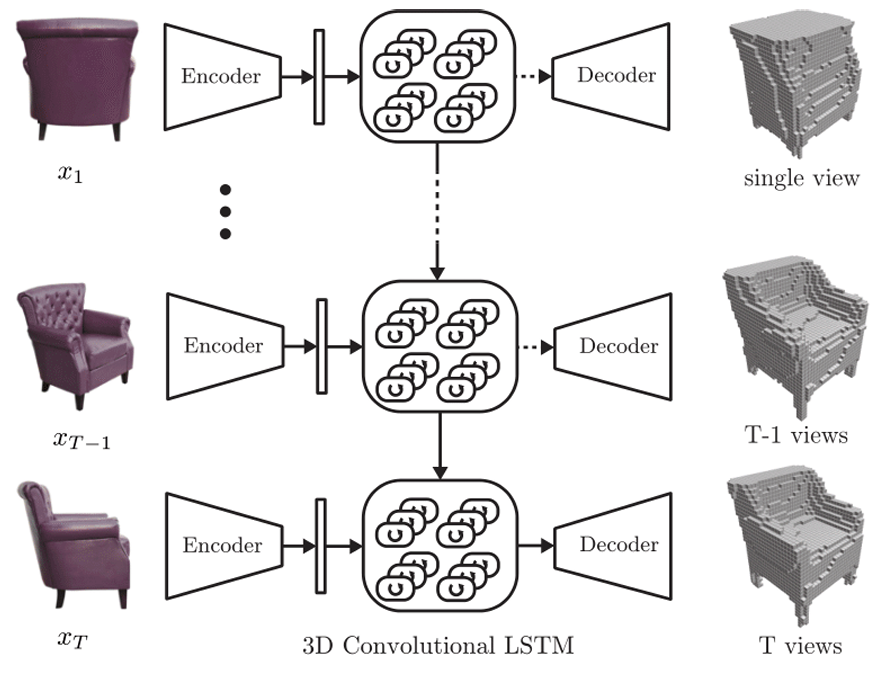
<br>


The authors employ an encoder-decoder architecture that utilizes a modified version of LSTM known as 3D-LSTM. In this architecture, the encoder generates compressed representations of the input views, which are then fed into the 3D-LSTM. These compressed views are used to remove occlusions from the predicted voxel grid. The initial image provides a general shape overview of the 3D object, while subsequent images offer additional details about its shape, leading to a more accurate and realistic voxel grid representation.

You can think of this problem as a **classification problem** where for each pixel in the voxel grid we would like to output a probability of whether that pixel is **occupied** or not

In [1]:

import numpy as np 
import pandas as pd
# Input data files are available in the read-only "../input/" directory


import matplotlib.pyplot as plt

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

import tarfile 

from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shapenet-3dr2n2/__notebook_source__.ipynb
/kaggle/input/shapenet-3dr2n2/ShapeNetVox32.tgz
/kaggle/input/shapenet-3dr2n2/ShapeNetRendering.tgz


# Data Preparation

Extract the vox grid data

In [2]:

# open file 
file = tarfile.open('/kaggle/input/shapenet-3dr2n2/ShapeNetVox32.tgz') 
print(file)
# extracting file 
file.extractall('./dataset') 

file.close() 


Running the below cell will give disk out of memory error, so I will pick some samples of the images not all (03.png, 11.png, and 17.png)

In [ ]:

# file = tarfile.open('/kaggle/input/shapenet-3dr2n2/ShapeNetRendering.tgz') 
# print(file)
# # extracting file 
# file.extractall('./images') 

# file.close() 

In [3]:
file = tarfile.open('/kaggle/input/shapenet-3dr2n2/ShapeNetRendering.tgz', 'r:*') 
print(file)

# get all members without extracting all files
members_lst = file.getmembers()
print(len(members_lst))


# get the names of the members
files_names = [m.name for m in members_lst]
print(len(files_names))


# filter names 03, 11, 17.png
files_series = pd.Series(files_names).str.contains('03.png|11.png|17.png')

mems_arr = np.array(members_lst)

members_lst = mems_arr[files_series.index[files_series == True].tolist()]

print(len(members_lst))

# extract the selected files
file.extractall('./images', members = members_lst)
print("---- Done ----")
file.close()

1225967
1225967
131352
---- Done ----


In [4]:
!ls

dataset  images


We can see that we have 2 folders: 
* dataset: for the vox grids
* images: for the corresponding object views

In [6]:
os.listdir("./dataset/ShapeNetVox32/")[:3]

['03636649', '04401088', '04379243']

In [7]:
os.listdir("./dataset/ShapeNetVox32/03636649/")[:3]

['d5a67642ff0a2908dbfbef883e8d10aa',
 '6e913f0b67bb638288c10250d0e7fba1',
 'aad04909cf72df68bd038489dd82490c']

In [9]:
os.listdir("./dataset/ShapeNetVox32/03636649/d5a67642ff0a2908dbfbef883e8d10aa")

['model.binvox']

we can see that the model is stored as a binvox (binary voxel)

In [11]:
class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).

    dims, translate and scale are the model metadata.

    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.

    scale and translate relate the voxels to the original model coordinates.

    To translate voxel coordinates i, j, k to original coordinates x, y, z:

    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]

    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)


def read_binvox(file_path):
    """
    input: binvox file path
    returns voxel object
    """
    with open(file_path, 'rb') as f:
        extension = f.readline()
        dims = [int(d) for d in f.readline().split(b" ")[1:]]
        translate = [float(t) for t in f.readline().split(b" ")[1:]]
        scale = float(f.readline().split(b" ")[1])
        f.readline()
        fileString = f.read()
        raw_data = np.frombuffer(fileString, dtype=np.uint8)
        values, counts = raw_data[::2], raw_data[1::2]
        data = np.repeat(values, counts)#.astype(bool)
        data = torch.tensor(data.reshape(dims))
        #data = np.transpose(data, (0, 2, 1))
        vox = Voxels(data, dims, translate, scale, "xyz")
    return vox

def plot_vox_data(arr):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(arr, edgecolor='k')
    plt.show()
    

The above read_binvox function takes the path as input and reads the binary file line by line to convert it to a numpy array/tensor

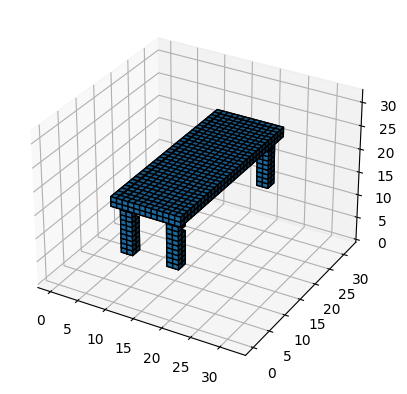

In [12]:
fp = "./dataset/ShapeNetVox32/04379243/bb201d4811ab271ecf5469d07a8db811/model.binvox"

vox = read_binvox(fp)
plot_vox_data(vox.data)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_root_dir, vox_root_dir):
        self.img_root_dir = img_root_dir
        self.vox_root_dir = vox_root_dir
        self.data = []

        for category in os.listdir(vox_root_dir):
            if ".tgz" in category:
                continue
            category_vox_path = os.path.join(vox_root_dir, category)
            category_img_path = os.path.join(img_root_dir, category)
            
            for model in os.listdir(category_vox_path):
                vox_model_path = os.path.join(category_vox_path, model)
                img_model_path = os.path.join(category_img_path, model)
                
                vox_full_path = os.path.join(vox_model_path, "model.binvox")
                imgs_path = os.path.join(img_model_path, 'rendering')
                if os.path.isdir(imgs_path):
                    #self.data.append([vox_full_path, os.path.join(imgs_path, "03.png")])
                    imgs_lst = []
                    for img in os.listdir(imgs_path):
                        full_img_path = os.path.join(imgs_path, img)
                        imgs_lst.append(full_img_path)
                        
                    self.data.append([vox_full_path, imgs_lst])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        vox_path, imgs_paths = self.data[idx]
        vox_arr = read_binvox(vox_path).data
        img_arr = torch.stack([read_image(p) for p in imgs_paths]) #read_image(imgs_paths)
        return vox_arr.to(torch.float32), img_arr.to(torch.float32)/255.0

        
        

In [14]:
vox_root_dir = "./dataset/ShapeNetVox32/"
image_root_dir = "./images/ShapeNetRendering/"

train_ds = CustomDataset(image_root_dir, vox_root_dir )

In [15]:
vox_arr, img_arr = train_ds[0]

In [16]:
vox_arr.shape, img_arr.shape

(torch.Size([32, 32, 32]), torch.Size([3, 4, 137, 137]))

I have decided to take 3 views of the object as input and use them to predict the voxel grid so the train_ds sample will have: 
* (N_images = 3, C = 3, H = 137, W = 137) as shape 
* the voxel grid of shape (32 x 32 x 32)

# Modeling

In [17]:
class Encoder(nn.Module):
    def __init__(self, in_shape):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels = in_shape,
                            out_channels = 96,
                            kernel_size = 7,
                            padding = 3)
        self.m1 = nn.MaxPool2d(2)
        self.a1 = nn.LeakyReLU(0.1)
        
        self.c2 = nn.Conv2d(in_channels = 96,
                            out_channels = 128,
                            kernel_size = 3,
                            padding = 1)
        
        self.m2 = nn.MaxPool2d(2)
        self.a2 = nn.LeakyReLU(0.1)
        
        self.c3 = nn.Conv2d(in_channels = 128,
                            out_channels = 256,
                            kernel_size = 3,
                            padding = 1)
        self.m3 = nn.MaxPool2d(2)
        self.a3 = nn.LeakyReLU(0.1)
        
        self.c4 = nn.Conv2d(in_channels = 256,
                            out_channels = 256,
                            kernel_size = 3,
                            padding = 1)
        self.m4 = nn.MaxPool2d(2)
        self.a4 = nn.LeakyReLU(0.1)
        
        self.c5 = nn.Conv2d(in_channels = 256,
                            out_channels = 256,
                            kernel_size = 3,
                            padding = 1)
        
        self.m5 = nn.MaxPool2d(2)
        self.a5 = nn.LeakyReLU(0.1)
        
        self.c6 = nn.Conv2d(in_channels = 256,
                            out_channels = 256,
                            kernel_size = 3,
                            padding = 1)
        self.m6 = nn.MaxPool2d(2)
        self.a6 = nn.LeakyReLU(0.1)
        
        self.flat7 = nn.Flatten()
        self.fc7 = nn.Linear(1024, 1024)
    
    def forward(self, x):
        x = self.c1(x)
        #print("c1", x.shape)
        x = self.m1(x)
        #print("m1", x.shape)
        x = self.a1(x)
        x = self.c2(x)
        #print("c2", x.shape)
        x = self.m2(x)
        #print("m2", x.shape)
        x = self.a2(x)
        x = self.c3(x)
        #print("c3", x.shape)
        x = self.m3(x)
        #print("m3", x.shape)
        x = self.a3(x)
        x = self.c4(x)
        #print("c4", x.shape)
        x = self.m4(x)
        #print("m4", x.shape)
        x = self.a4(x)
        x = self.c5(x)
        #print("c5", x.shape)
        x = self.m5(x)
        #print("m5", x.shape)
        x = self.a5(x)
        x = self.c6(x)
        #print("c6", x.shape)
        x = self.m6(x)
        #print("m6", x.shape)
        x = self.a6(x)
        x = self.flat7(x)
        x = self.fc7(x)
        
        return x

####  $f_t$ = $\sigma$($W_f$ $T(x_t)$ +$U_f$ $h_{t-1}+ b_f)$ 
####  $i_t$ = $\sigma$($W_i T(x_t) + U_i h_{t-1} + b_i$) 
####  $s_t$ = $f_t . s_{t-1} + i_t * tanh(W_s . T(x_t) + U_s * h_{t-1} + b_s)$
####  $h_t$ = $tanh(s_t)$

In [18]:
class LSTM3D(nn.Module):
    def __init__(self, N, Nh, fc_output_dim):
        super().__init__()
        self.N = N
        self.Nh = Nh
        self.fc_output_dim = fc_output_dim
        
        self.fc_f = nn.Linear(fc_output_dim, Nh*N*N*N)
        self.fc_i = nn.Linear(fc_output_dim, Nh*N*N*N)
        self.fc_s = nn.Linear(fc_output_dim, Nh*N*N*N)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.conv_f = nn.Conv3d(Nh, Nh, 3, padding = 1)
        self.conv_i = nn.Conv3d(Nh, Nh, 3, padding = 1)
        self.conv_s = nn.Conv3d(Nh, Nh, 3, padding = 1)
        
    def forward(self, x, ht_1, st_1):
        """
        ht is the one that gets passed to the decoder
        """
        fc_out = self.fc_f(x).view(-1,self.Nh,self.N,self.N,self.N)
        #print(fc_out.shape)
        convf = self.conv_f(ht_1)
        #print(ht_1.shape, convf.shape)
        ft = fc_out + convf
        ft = self.sigmoid(ft)
        #print(ft.shape)
        fc_out = self.fc_i(x).view(-1,self.Nh,self.N,self.N,self.N)
        #print(fc_out.shape)
        it = fc_out + self.conv_i(ht_1)
        it = self.sigmoid(it)
        #print(it.shape)
        fc_out = self.fc_s(x).view(-1,self.Nh,self.N,self.N,self.N)
        #print(fc_out.shape)
        temp = self.tanh(fc_out + self.conv_s(ht_1))
        
        st = ft * st_1 + it * temp
        
        ht = self.tanh(st)
        return ht, st
        
        

In [19]:
class Decoder(nn.Module):
    def __init__(self, Nh = 128):
        super().__init__()
        self.deconv1 = nn.Conv3d(Nh, Nh, 3, padding = 1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.deconv2 = nn.Conv3d(Nh,Nh , 3, padding = 1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.deconv3 = nn.Conv3d(Nh, 64, 3, padding = 1)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.deconv4 = nn.Conv3d(64, 32, 3, padding = 1)
        #self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.deconv5 = nn.Conv3d(32, 1, 3, padding = 1)
        #self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.output = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.up1(x)
        x = self.deconv1(x)
        
        
        x = self.up2(x)
        x = self.deconv2(x)
        
        
        x = self.up3(x)
        x = self.deconv3(x)
        
        
        #x = self.up4(x)
        x = self.deconv4(x)
        
        #x = self.up5(x)
        x = self.deconv5(x)
        
        
        x = self.output(x)
        
        return x
        

In [20]:
torch.cuda.empty_cache()

In [21]:
# lstm = LSTM3D(4, 128, 1024)
# e = Encoder(4)
# d = Decoder(128)
# out = e(torch.rand((1,4,137,137)))
# print(out.shape)
# ol = lstm(out, torch.rand((1, 128,4,4,4)), torch.rand((1, 128,4,4,4)))
# print(ol[0].shape, ol[1].shape)
# vox_out = d(ol[0])
# print(vox_out.shape)
# #v = torch.argmax(vox_out, axis = 1)[0]
# v = vox_out > 0.5

In [22]:
# plot_vox_data(v.squeeze())

In [23]:
BCE_loss = nn.BCELoss()#CE_loss = nn.CrossEntropyLoss()

In [24]:
encoder_net = Encoder(4)
lstm_3d_net = LSTM3D(4, 128, 1024)
decoder_net = Decoder(128)

In [25]:
encoder_optim = torch.optim.Adam(encoder_net.parameters(), lr=0.00005)
lstm_optim = torch.optim.Adam(lstm_3d_net.parameters(), lr=0.00005)
decoder_optim = torch.optim.Adam(decoder_net.parameters(), lr=0.00005)

enc_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optim, step_size=50, gamma=0.5)
lstm_scheduler = torch.optim.lr_scheduler.StepLR(lstm_optim, step_size=50, gamma=0.5)
dec_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optim, step_size=50, gamma=0.5)

In [32]:
BATCH_SIZE = 8
EPOCHS = 1000

In [33]:
train_dataloader = DataLoader(train_ds, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False,
                              num_workers = 4)



In [28]:
loss_history = []

In [35]:
IS_CUDA_AVAILABLE = torch.cuda.is_available()

In [36]:
if IS_CUDA_AVAILABLE:
    encoder_net = encoder_net.cuda()
    lstm_3d_net = lstm_3d_net.cuda()
    decoder_net = decoder_net.cuda()

Lets overfit to the data by training on 8 samples only to check if the model is capable of learning or not

In [38]:
for i in range(EPOCHS):
    epoch_loss = 0
    for batch_idx, (vox_true, x_img) in enumerate(train_dataloader):
        if x_img.shape[0] != BATCH_SIZE:
            continue
        
        hidden_state = [torch.zeros((1, 128,4,4,4)), 
                        torch.zeros((1, 128,4,4,4))]
        
        if IS_CUDA_AVAILABLE:
            x_img = x_img.cuda()
            vox_true = vox_true.cuda()
            hidden_state = [hidden_state[0].cuda(), hidden_state[1].cuda()]
            
            
        encoder_optim.zero_grad()
        lstm_optim.zero_grad()
        decoder_optim.zero_grad()
        
        # loop over the multiple views to feed the LSTM3D model
        for j in range(x_img.shape[1]):
            x = x_img[:, j, :, :, :]
            
            # detach to avoid calculating the gradient for the previous states
            hidden_state[0].detach_()
            hidden_state[1].detach_()


            img_encoded = encoder_net(x)
            
            hidden_state = lstm_3d_net(img_encoded, *hidden_state)
            
        vox_pred = decoder_net(hidden_state[0])
        
        props = vox_pred.squeeze()
        if IS_CUDA_AVAILABLE:
            props = props.cuda()
            
        loss = BCE_loss(props, vox_true)
        
        loss.backward()
        
        encoder_optim.step()
        lstm_optim.step()
        decoder_optim.step()
        
        enc_scheduler.step()
        lstm_scheduler.step()
        dec_scheduler.step()
        
        epoch_loss += loss.item()
        break
        
    if i %50 == 0:
        print(f"epoch: {i} -- Loss: {epoch_loss}")

    loss_history.append(epoch_loss)


epoch: 0 -- Loss: 0.70583176612854
epoch: 50 -- Loss: 0.16161051392555237
epoch: 100 -- Loss: 0.12436318397521973
epoch: 150 -- Loss: 0.10258843004703522
epoch: 200 -- Loss: 0.09035495668649673
epoch: 250 -- Loss: 0.08455434441566467
epoch: 300 -- Loss: 0.0813305526971817
epoch: 350 -- Loss: 0.07965371012687683
epoch: 400 -- Loss: 0.07880837470293045
epoch: 450 -- Loss: 0.0783834382891655
epoch: 500 -- Loss: 0.0781693160533905
epoch: 550 -- Loss: 0.07806100696325302
epoch: 600 -- Loss: 0.07800616323947906
epoch: 650 -- Loss: 0.07797836512327194
epoch: 700 -- Loss: 0.07796420156955719
epoch: 750 -- Loss: 0.07795700430870056
epoch: 800 -- Loss: 0.07795349508523941
epoch: 850 -- Loss: 0.07795242220163345
epoch: 900 -- Loss: 0.07795213907957077
epoch: 950 -- Loss: 0.077952079474926


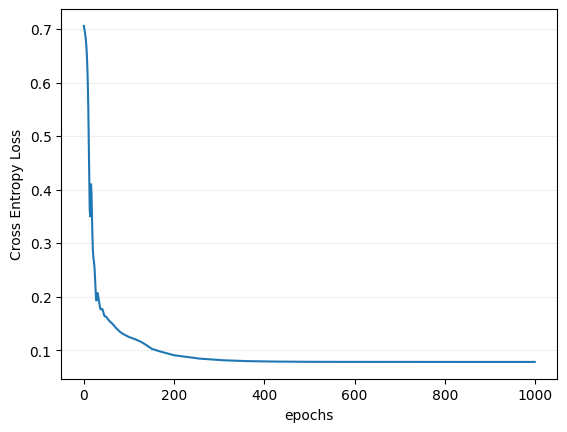

In [39]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.grid(axis='y', alpha = 0.2)

In [40]:
# torch.save(encoder_net.state_dict(), "/kaggle/working/encoder_net.h5")
# torch.save(lstm_3d_net.state_dict(), "/kaggle/working/lstm_3d_net.h5")
# torch.save(decoder_net.state_dict(), "/kaggle/working/decoder_net.h5")

Lets take a sample for testing (we are cheating by using the train_ds but this is just an exercise)

torch.Size([32, 32, 32]) torch.Size([3, 4, 137, 137])


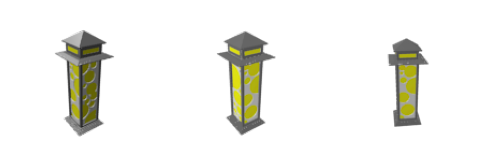

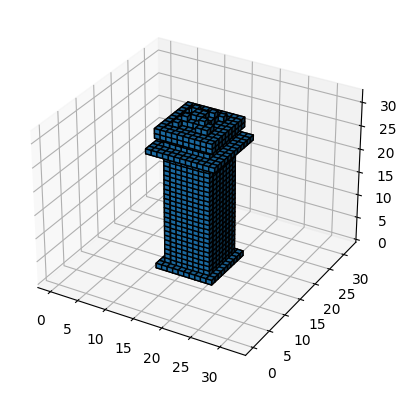

In [54]:
y, x_img = train_ds[2]

print(y.shape, x_img.shape)

fig, axs = plt.subplots(1, x_img.shape[0], figsize = (5, 5), tight_layout = True)

for _ in range(x_img.shape[0]):
    axs[_].imshow(x_img[_, ...].permute(1, 2, 0))
    axs[_].axis("off")
    
plot_vox_data(y)


In [49]:

x_img = x_img[None, ...]
hidden_state = [torch.zeros((1, 128,4,4,4)).cuda(), torch.zeros((1, 128,4,4,4)).cuda()]

x_img = x_img.cuda()
for i in range(x_img.shape[1]):
    x = x_img[:, i, :, :, :]    
    img_encoded = encoder_net(x)#.cuda()
    hidden_state = lstm_3d_net(img_encoded, *hidden_state)

out = decoder_net(hidden_state[0])
print(out.shape)

torch.Size([1, 1, 32, 32, 32])


torch.Size([32, 32, 32])


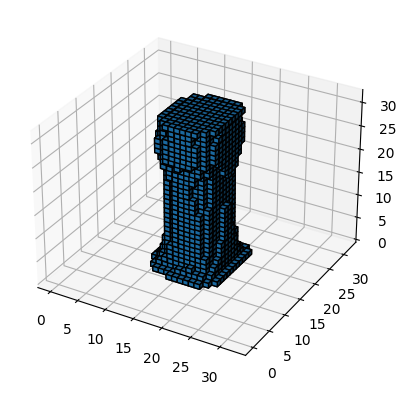

In [55]:
vox_pred = (out.squeeze()>0.2)
print(vox_pred.shape)
plot_vox_data(vox_pred)


Next Steps:
* Train the model on the whole dataset
* Split the data from train/testing
* Calculate the metrics mentioned in the paper like voxel Intersection-over-Union (IoU)